## Setup

You need to define your data folder before using this notebook.
Kill this notebook, run `export PYCOX_DATA_DIR=path/to/folder` and launch this notebook again.

In [56]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
import logging
import numpy as np
import pandas as pd

assert os.getenv("PYCOX_DATA_DIR"), "env variable PYCOX_DATA_DIR must be set"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The script below downloads the data if you don't have it locally (this can take up to 10min!). You will need Kaggle credentials, see: https://github.com/Kaggle/kaggle-api#api-credentials.

Then, it generates the covariates file if it doesn't exist in your data folder.

### Loading data

In [57]:
from pycox.datasets import kkbox_v1

kkbox_v1._path_dir.mkdir(exist_ok=True)

train_file = kkbox_v1._path_dir / "train.csv"
members_file = kkbox_v1._path_dir / "members_v3.csv"
transactions_file = kkbox_v1._path_dir / "transactions.csv"

any_prior_file_missing = (
    not train_file.exists()
    or not members_file.exists()
    or not transactions_file.exists()
)

covariate_file = kkbox_v1._path_dir / "covariates.feather"
is_covariate_file_missing = not covariate_file.exists()

if is_covariate_file_missing:
    print("Covariate file missing!")
    # We need to download any missing prior file
    # before producing the final covariate file.
    if any_prior_file_missing:
        print("Prior files missing!")
        kkbox_v1._setup_download_dir()
        kkbox_v1._7z_from_kaggle()
    kkbox_v1._csv_to_feather_with_types()
    kkbox_v1._make_survival_data()
    kkbox_v1._make_survival_covariates()
    kkbox_v1._make_train_test_split()

### Preprocessing

In [58]:
covariates = pd.read_feather(kkbox_v1._path_dir / "covariates.feather")
covariates

,msno,event,n_prev_churns,days_between_subs,duration,days_since_reg_init,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,city,gender,registered_via,age_at_start,strange_age,nan_days_since_reg_init,no_prev_churns
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,1.0,0.0,0.0,5.0,4549.0,7.0,0.0,0.0,0.0,0.0,15,female,9,28.0,0.0,0.0,1.0
1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,1.0,0.0,0.0,410.0,1062.0,410.0,1788.0,1788.0,0.0,0.0,6,female,3,21.0,0.0,0.0,1.0
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0.0,0.0,0.0,119.0,892.0,30.0,99.0,99.0,1.0,0.0,1,NaN,7,-0.0,1.0,0.0,1.0
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,1.0,0.0,0.0,413.0,1535.0,31.0,149.0,149.0,1.0,0.0,15,male,9,24.0,0.0,0.0,1.0
4,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0.0,0.0,0.0,790.0,121.0,30.0,149.0,149.0,1.0,0.0,1,NaN,7,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2646741,zzz9+ZF4+GMyt63oU8xfjo1EkvRqH5OINlES0RUJI6I=,1.0,0.0,0.0,386.0,0.0,30.0,129.0,129.0,1.0,0.0,1,NaN,7,0.0,1.0,0.0,1.0
2646742,zzzF1KsGfHH3qI6qiSNSXC35UXmVKMVFdxkp7xmDMc0=,0.0,0.0,0.0,27.0,7.0,30.0,149.0,149.0,1.0,0.0,4,male,3,26.0,0.0,0.0,1.0
2646743,zzzN9thH22os1dRS0VHReY/8FTfGHOi86//d+wGGFsQ=,1.0,0.0,0.0,335.0,-1.0,30.0,99.0,99.0,1.0,0.0,NaN,NaN,NaN,-1.0,0.0,1.0,1.0
2646744,zzztsqkufVj9DPVJDM3FxDkhlbCL5z4aiYxgPSGkIK4=,1.0,0.0,0.0,7.0,125.0,7.0,0.0,0.0,0.0,0.0,1,female,3,30.0,0.0,0.0,1.0


In [59]:
def extra_cleaning(df):
    # remove id
    df.pop("msno")

    # ordinal encode gender
    df["gender"] = df["gender"].astype(str)
    gender_map = dict(zip(df["gender"].unique(), range(df["gender"].nunique())))
    df["gender"] = df["gender"].map(gender_map)
    
    # remove tricky np.nan in city, encoded as int
    df["city"] = df["city"].astype(str).replace("nan", -1).astype(int)
    
    # same for registered via
    df["registered_via"] = df["registered_via"].astype(str).replace("nan", -1).astype(int)
    
    return df

In [60]:
covariates = extra_cleaning(covariates)
covariates.isna().sum().sum()

0

In [61]:
from sksurv.datasets import get_x_y

X, y = get_x_y(covariates, ("event", "duration"), pos_label=1)

## YASGBT IBS evolution on n_iter

Let's train or load our YASGBT model with 1000 tree predictors.

In [62]:
import dill
from pathlib import Path

from models.yasgbt import YASGBT
from model_selection.cross_validation import run_cv

filename = "yasgbt_1000.pkl"

if not Path(filename).exists():
    yasgbt = YASGBT(
        sampling_strategy="uniform",
        n_iter=1000,
        show_progressbar=True,
    )
    yasgbt.name = "YASGBT-1000"
    run_cv(X, y, yasgbt, single_fold=True)
    dill.dump(yasgbt, open(filename, "wb+"))
else:
    yasgbt = dill.load(open(filename, "rb"))

We then subsequently prune the estimator with a fix number of predictors and plot the evolution of the Brier Scores.

In [65]:
from copy import deepcopy
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold

from model_selection.cross_validation import get_scores
from plot.brier_score import plot_brier_scores


def plot_brier_scores_various_max_predictors(yasgbt, X_, y_, subset=1, is_train=False):
    
    assert subset <= 1
    subset_idx = int(X_.shape[0] * subset)
    X = X_.iloc[:subset_idx]
    y = y_[:subset_idx]
    
    min_date = y["duration"].min() + 1
    max_date = y["duration"].max() - 1
    times = np.linspace(min_date, max_date, 100)

    # Yields same indices as cross validation used above
    train_idxs, val_idxs = next(KFold().split(X))
    X_train, y_train = X.iloc[train_idxs], y[train_idxs]
    X_val, y_val = X.iloc[val_idxs], y[val_idxs]

    yasgbt.show_progressbar = False

    all_scores = []
    all_max_predictors = [5, 10, 20, 50, 100, 200, 500, 1000]
    for max_predictors in tqdm(all_max_predictors):
        yasgbt_copy = deepcopy(yasgbt)
        yasgbt_copy.hgbc_._predictors = yasgbt_copy.hgbc_._predictors[:max_predictors]
        yasgbt_copy.hgbc_.max_iter = max_predictors
        if is_train:
            filename = "yasgbt_train_scores.pkl"
            scores = get_scores(yasgbt_copy, y_train, X_train, y_train, times)
        else:
            filename = "yasgbt_val_scores.pkl"
            scores = get_scores(yasgbt_copy, y_train, X_val, y_val, times)
        all_scores.append(scores)

    df_yasgbt_scores = pd.DataFrame(all_scores)
    df_yasgbt_scores["model"] = "YASGBT-" + pd.Series(all_max_predictors).astype(str)
    df_yasgbt_scores.to_pickle(filename)

    plot_brier_scores(df_yasgbt_scores)    

  0%|          | 0/8 [00:00<?, ?it/s]

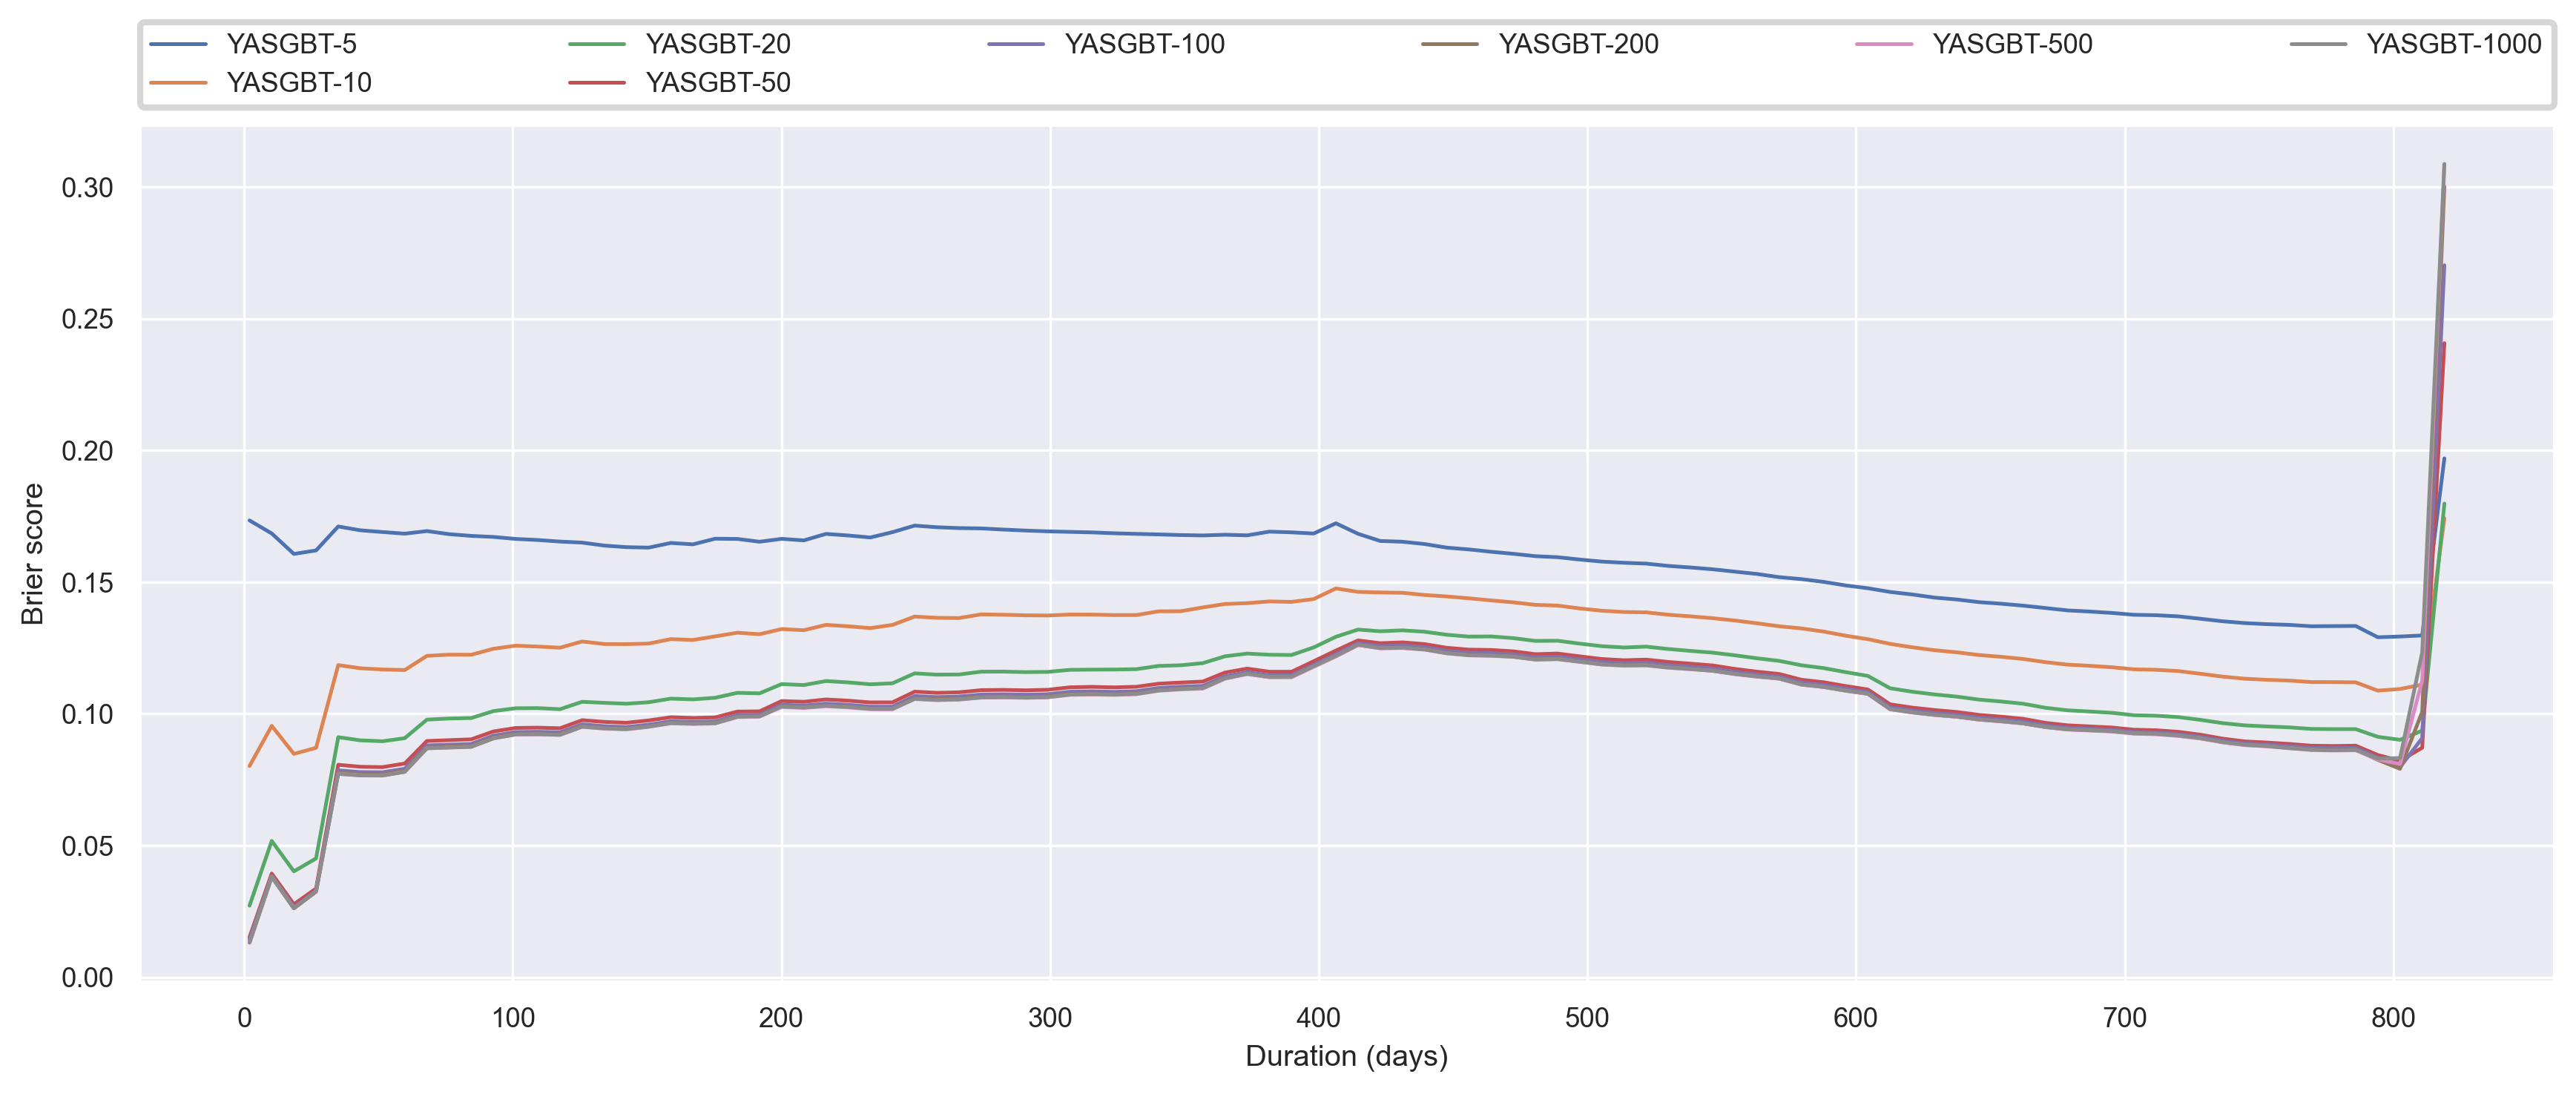

In [66]:
plot_brier_scores_various_max_predictors(yasgbt, X, y, subset=.1, is_train=False)

Same experience with the training set to look for overfitting.

  0%|          | 0/8 [00:00<?, ?it/s]

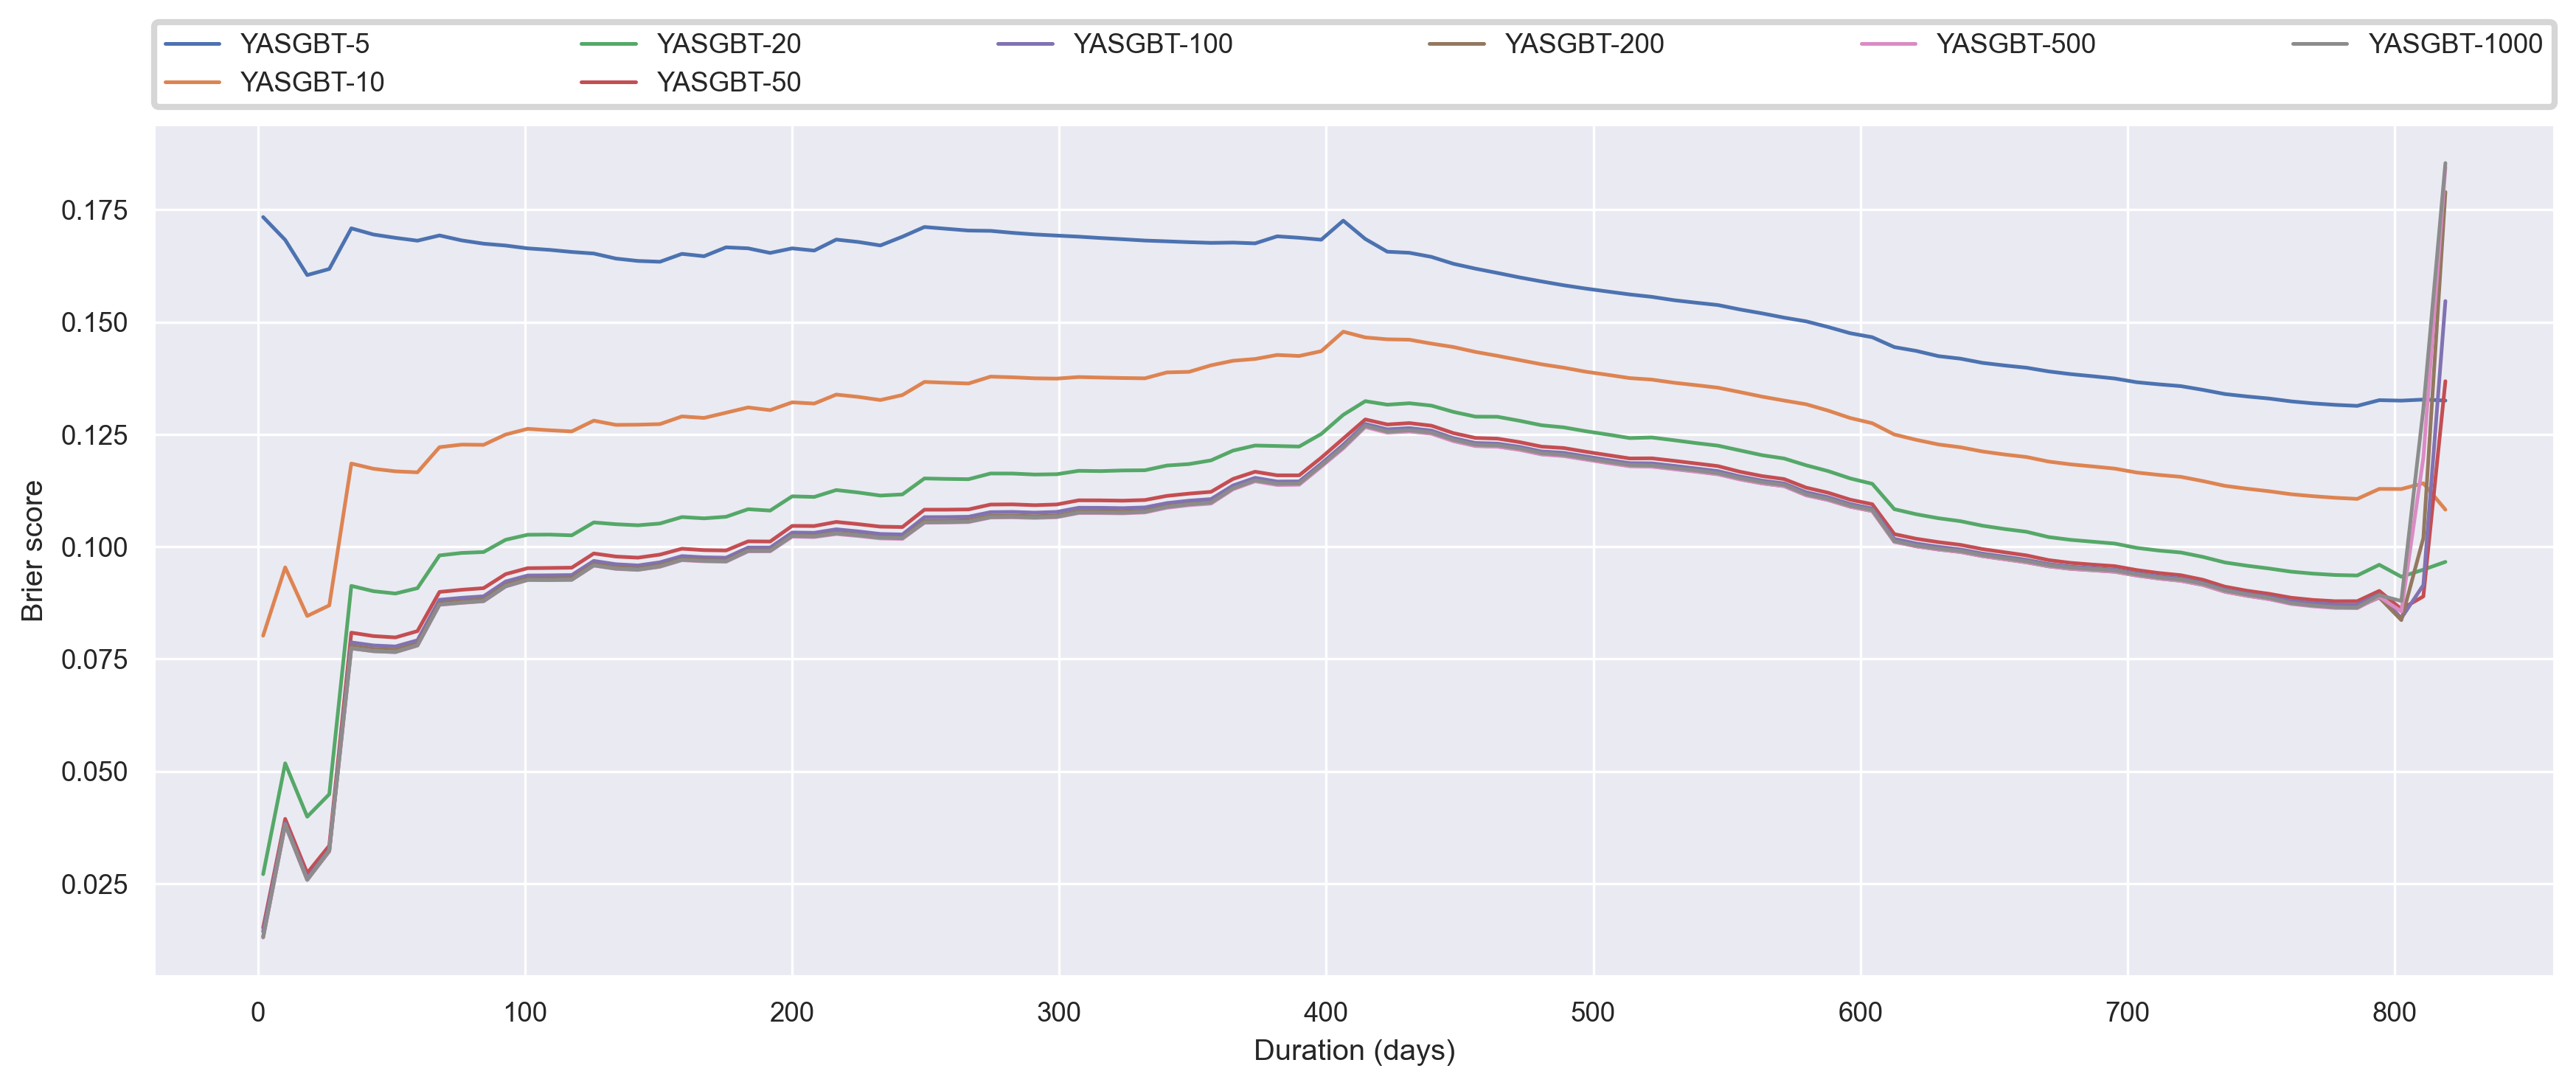

In [67]:
plot_brier_scores_various_max_predictors(yasgbt, X, y, subset=.1, is_train=True)

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

def plot_bs_gap(df_score_train, df_score_val):
    cols = df_score_train.columns
    col_to_idx = dict(zip(cols, range(len(cols))))
    score_train, score_val = df_score_train.values, df_score_val.values
    
    fig, ax = plt.subplots(figsize=(14, 5), dpi=300)
    for row_train, row_val in zip(score_train, score_val):
        brier_score_val = np.array(row_val[col_to_idx["brier_scores"]])
        brier_score_train = np.array(row_train[col_to_idx["brier_scores"]])
        bs_diffs =  brier_score_val - brier_score_train
        times = row_train[col_to_idx["times"]]
        model = row_train[col_to_idx["model"]]
        ax.plot(
            times,
            bs_diffs,
            label=model,
        )
    plt.xlabel("Duration (days)")
    plt.ylabel("Brier score val - train gap")
    legend = plt.legend(
        bbox_to_anchor=(0, 1.02, 1, 0.2),
        loc="lower left",
        mode="expand",
        borderaxespad=0,
        ncol=6,
        facecolor='white',
    );
    plt.ylim([-0.01, 0.01])
    frame = legend.get_frame()
    frame.set_linewidth(2)

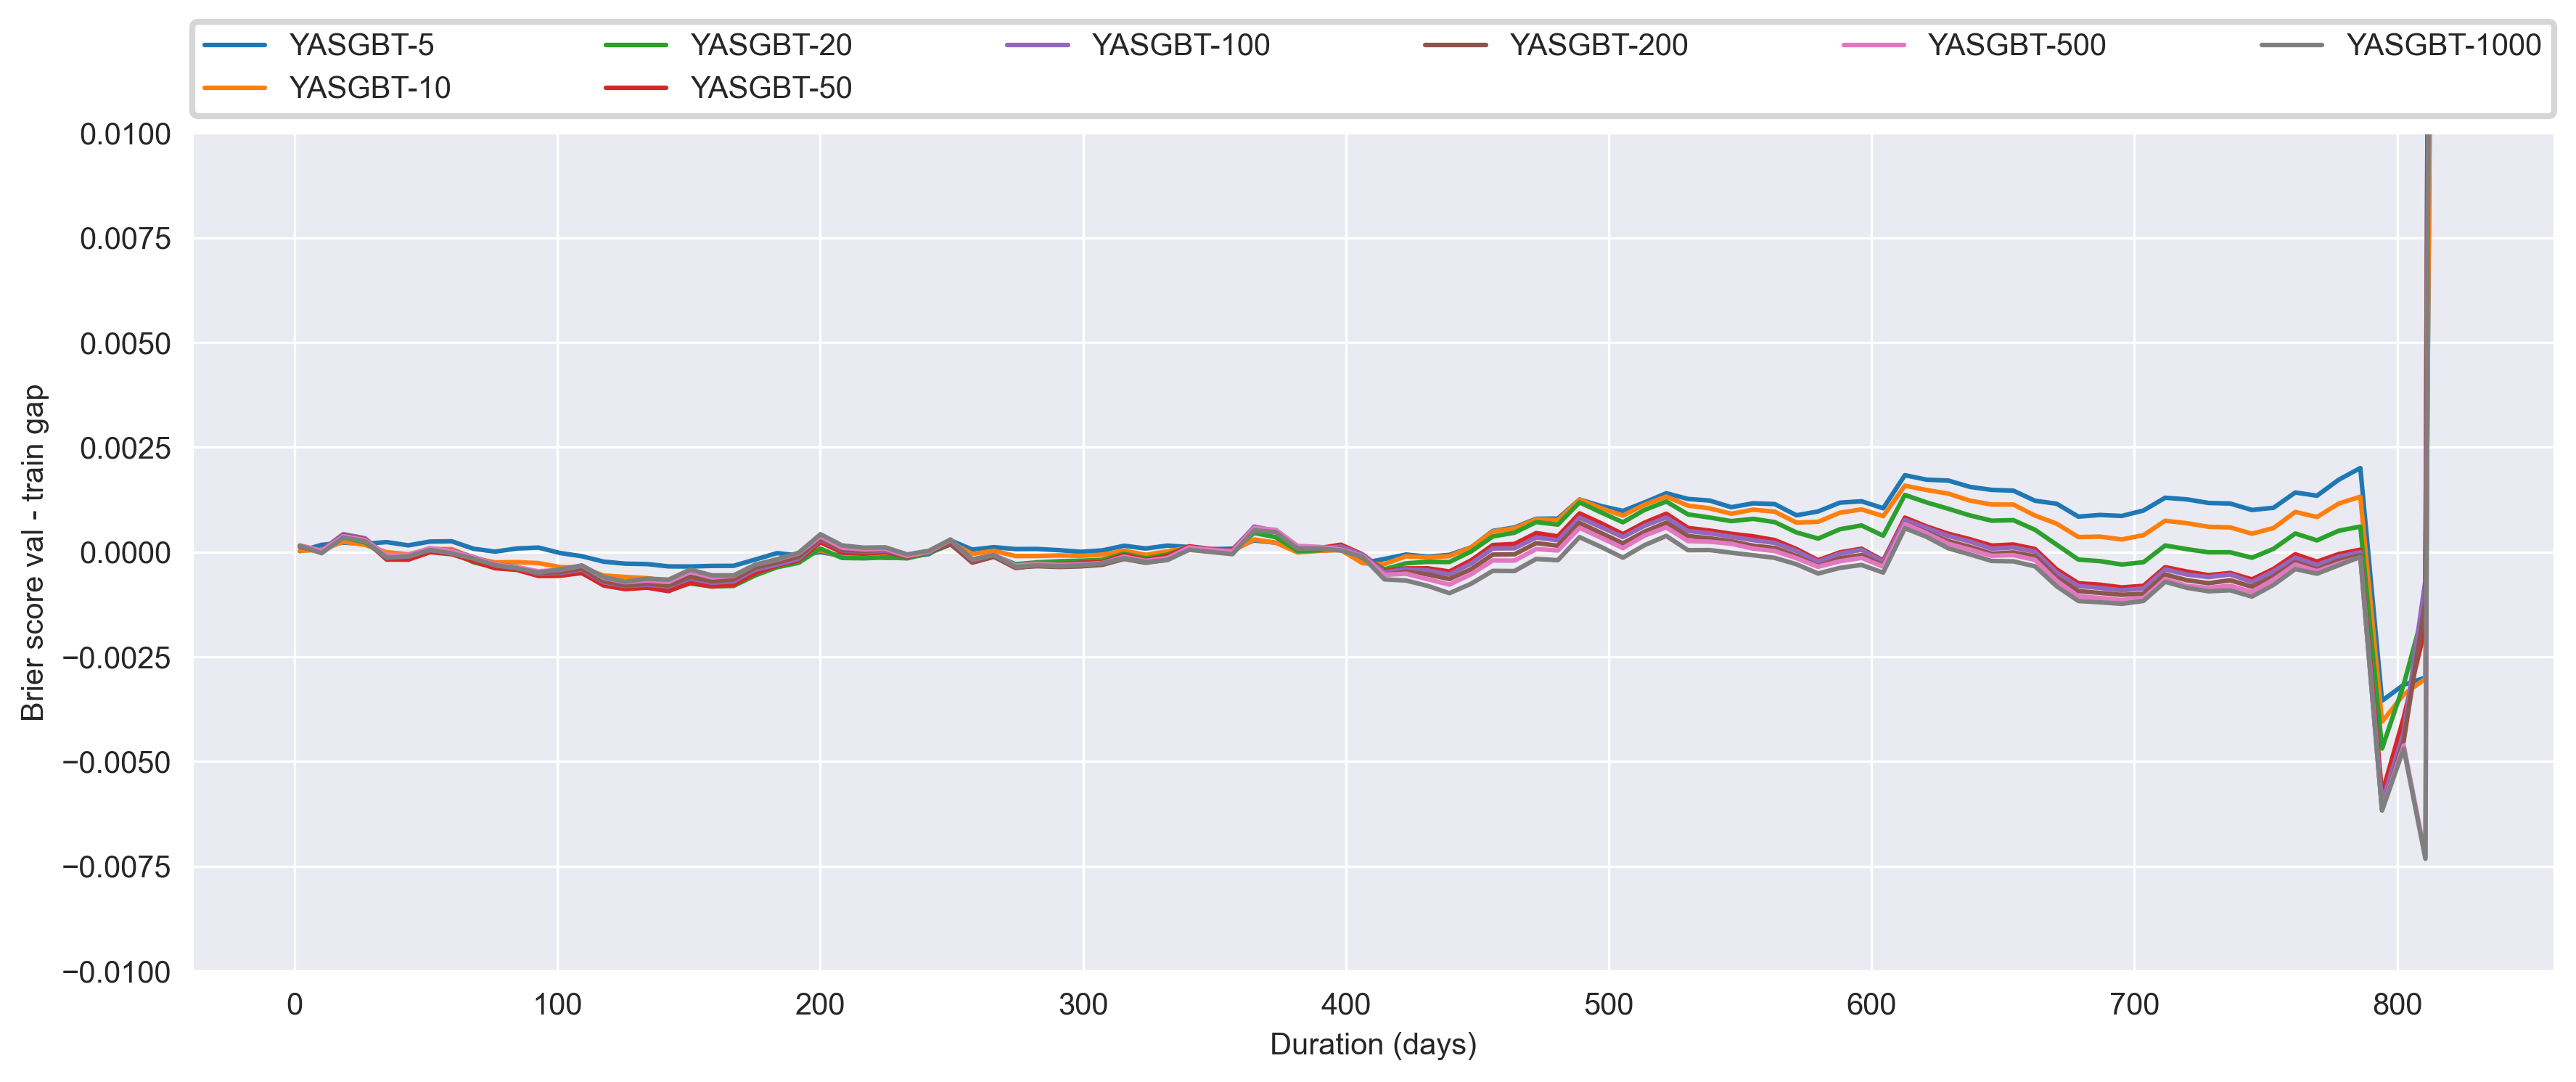

In [12]:
df_score_train = pd.read_pickle("yasgbt_train_scores.pkl")
df_score_val = pd.read_pickle("yasgbt_val_scores.pkl")

plot_bs_gap(df_score_train, df_score_val)